# Belief Networks in Julia with `BayesNets.jl`

In this notebook we will use the [`BayesNets` julia package](https://github.com/sisl/BayesNets.jl) to build belief networks.

## Example 1: Inspector Clouseau

Here we re-do the Inspector Clouseau example from Barber, but this time by constructing a belief network.

>**Barber Example 1.3 (Inspector Clouseau)**
>
>Inspector Clouseau arrives at the scene of a crime. The victim lies dead in the room and the inspector quickly ﬁnds the murder weapon, a Knife (`K`). The Butler (`B`) and Maid (`M`) are his main suspects. The inspector has a prior belief of 0.8 that the Butler is the murderer, and a prior belief of 0.2 that the Maid is the murderer. These probabilities are independent in the sense that $p(B, M) = p(B)p(M)$. (It is possible that both the Butler and the Maid murdered the victim or neither). The inspector’s *prior* criminal knowledge can be formulated mathematically as follows.

(Here we use short-hand notation, e.g. $p(B)$ means the (*a priori*) probability that the butler is the murder, $p(K|B,\lnot M$ means the probability that the knife was used given that the butler was the murder and the maid was not.)
>
>$$
\begin{align}
p(B) & = 0.6 \\
p(M) & = 0.2 \\
p(M, B) & = p(M)p(B)
\end{align}
$$
>
>$$
\begin{align}
p(K | \lnot B, \lnot M) & = 0.3 \\
p(K | \lnot B, M) & = 0.2 \\
p(K | B, \lnot M) & = 0.6 \\
p(K | B, M) & = 0.1
\end{align}
$$
>
>Assuming the knife is the murder weapon, what is the probability that the Butler is the murderer?

### Build the Network

A belief network is specified by variables and their conditional probabilities. To build the model, you describe the structure of network by defining nodes and links in a directed graph, and then assign the conditional probabilities (or priors) for each variable.

We have to be careful, because the convention for specifying the conditional probability (`DiscreteCPD`) is different from that in `pgmpy` and from (1.2.6) in Barber.  The *first* variable changes the fastest.  From the docs:

In [1]:
using BayesNets

In [2]:
?DiscreteCPD

search: DiscreteCPD Discrete DiscreteUniform DiscreteBayesNet



A categorical distribution, P(x|parents(x)) where all parents are discrete integers 1:N.

The ordering of `distributions` array follows the convention in Decision Making Under Uncertainty. Suppose a variable has three discrete parents. The first parental instantiation assigns all parents to their first bin. The second will assign the first parent (as defined in `parents`) to its second bin and the other parents to their first bin. The sequence continues until all parents are instantiated to their last bins.

This is equivalent to:

X,Y,Z 1,1,1 2,1,1 1,2,1 2,2,1 1,1,2 ...


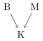

In [3]:
using BayesNets

model = DiscreteBayesNet() # uses variable values 1:N

# variable convention:  [False, True]
push!(model, DiscreteCPD(:B, [0.4, 0.6])) # :foo means symbol foo in Julia
push!(model, DiscreteCPD(:M, [0.8, 0.2]))

push!(model, DiscreteCPD(:K, [:B, :M], [2, 2], 
    [Categorical([0.7, 0.3]),
     Categorical([0.4, 0.6]), # B=T, M=F
     Categorical([0.8, 0.2]), # B=F, M=T
     Categorical([0.9, 0.1]),
    ]))

TODO: We can also make a more user-friendly model by using category names. (tried, but only partial success)

In [4]:
bn = BayesNet()

In [5]:
pB = NamedCategorical([:murderer, :not_murderer], [0.6, 0.4])

NamedCategorical with entries:
	  0.4000:  not_murderer
	  0.6000:  murderer


In [6]:
pB = NamedCategorical(["murderer", "not murderer"], [0.6, 0.4])

NamedCategorical with entries:
	  0.4000:  not murderer
	  0.6000:  murderer


In [7]:
CategoricalCPD(:B, pB)

CategoricalCPD{NamedCategorical{String}}(:B, Symbol[], Int64[], NamedCategorical{String}[NamedCategorical with entries:
	  0.4000:  not murderer
	  0.6000:  murderer
])

In [8]:
pM = NamedCategorical(["murderer", "not murderer"], [0.2, 0.8])

NamedCategorical with entries:
	  0.8000:  not murderer
	  0.2000:  murderer


In [9]:
push!(bn, CategoricalCPD(:B, pB), CategoricalCPD(:M, pM))

In [10]:
bn = BayesNet()
push!(bn, DiscreteCPD(:K, [:B, :M], [2, 2], [
    NamedCategorical(["knife used", "knife not used"], [0.3, 0.7]),  # note order:
    NamedCategorical(["knife used", "knife not used"], [0.6, 0.4]),  # p(K | B=T, M=F)
    NamedCategorical(["knife used", "knife not used"], [0.2, 0.8]),  # p(K | B=F, M=T)
    NamedCategorical(["knife used", "knife not used"], [0.1, 0.9])
    ]))

MethodError: MethodError: Cannot `convert` an object of type NamedCategorical{String} to an object of type Categorical{Float64}
Closest candidates are:
  convert(::Type{Categorical{T<:Real}}, !Matched::Array{S<:Real,1}) where {T<:Real, S<:Real} at /Users/mike/.julia/packages/Distributions/WHjOk/src/univariate/discrete/categorical.jl:45
  convert(::Type{Categorical{T<:Real}}, !Matched::Categorical{S<:Real}) where {T<:Real, S<:Real} at /Users/mike/.julia/packages/Distributions/WHjOk/src/univariate/discrete/categorical.jl:46
  convert(::Type{S}, !Matched::T<:(Union{CategoricalString{R}, CategoricalValue{T,R} where T} where R)) where {S, T<:(Union{CategoricalString{R}, CategoricalValue{T,R} where T} where R)} at /Users/mike/.julia/packages/CategoricalArrays/ucKV2/src/value.jl:91
  ...

### Inference in Belief Networks

From Barber, we can solve for a query pdf such as $p(B|K)$ using variable elimination as follows:

$$
\begin{align}
p(B|K) & = \sum_{m} p(B,m|K) \\
       & = \sum_{m} \frac{p(B,m,K)}{p(K)} \\
       & = \frac{p(B) \sum_{m} p(K|B,m)p(m)}{\sum_{b} p(b) \sum_{m} p(K|b,m) p(m)}
\end{align}
$$

Note how the summation variables are lowercase versions of the random variables to keep them distinct.  The capital variables are set from $p(B|K)$, but the summation variables are $b$ and $m$, which sum over the domains of $B$ and $M$ (which here are the same).  Filling in the values above,  we get

$$
\begin{align}
       & = \dfrac{0.6 \times (0.2 \times 0.1 + 0.8 \times 0.6)}{0.6 \times (0.2 \times 0.1 + 0.8 \times 0.6) + 0.4 \times (0.2 \times 0.2 + 0.8 \times 0.3)} \\
       & \approx 0.73
\end{align}
$$

To solve for $p(B|K = \textsf{true})$:

In [11]:
infer(model, :B, evidence=Assignment(:K=>2)) # K=True

,B,potential
,Int64,Float64
1,1,0.271845
2,2,0.728155


We can easily compute the probability for the other suspect $P(M|K)$

In [12]:
infer(model, :M, evidence=Assignment(:K=>2)) # K=True

,M,potential
,Int64,Float64
1,1,0.932039
2,2,0.0679612


And also add evidence. For example if we know that the maid could not have been present, $P(B|K=\textsf{true}, M=\textsf{false})$

In [13]:
infer(model, :B, evidence=Assignment(:K=>2, :M=>1)) # K=True, M=False

,B,potential
,Int64,Float64
1,1,0.25
2,2,0.75


This is the same result as in `pgmpy`.

The probability that neither of the suspects is the murderer can be computed as

In [14]:
infer(model, [:B, :M], evidence=Assignment(:K=>2)) # K=True

,B,M,potential
,Int64,Int64,Float64
1,1,1,0.23301
2,2,1,0.699029
3,1,2,0.038835
4,2,2,0.0291262


### Explaining away

#### Noisy fuel gauge

A simple example from Bishop (fig 8.21).

*Explaining away* is the concept that our beliefs about other potential causes can be "explained away" when we learn new information.

Consider a model of a noisy electric fuel gauge in an old and unreliable car.  The state of the guage $G$ indicates the fuel level $F$.  The gauge is electric, so it depends on the fuel level $F$ and the state of the battery $B$. For simplicity, assume the states are binary.

First we define the network.

$$
p(B = 1) = 0.9\\
p(F = 1) = 0.9
$$

In [16]:
using BayesNets
fg = DiscreteBayesNet()

In [17]:
pB = DiscreteCPD(:B, [0.1, 0.9]) # p(B = 0), p(B = 1)
pF = DiscreteCPD(:F, [0.1, 0.9]) # p(F)
push!(fg, pB, pF)

In [18]:
pB

,B,potential
,Int64,Float64
1,1,0.1
2,2,0.9


In [19]:
fg

Now we define the conditional probabilities:

$$
\begin{align}
p(G = 1 | B = 0, F = 0) = 0.1\\
p(G = 1 | B = 1, F = 0) = 0.2\\
p(G = 1 | B = 0, F = 1) = 0.2\\
p(G = 1 | B = 1, F = 1) = 0.8
\end{align}
$$

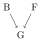

In [20]:
pGgBF = DiscreteCPD(:G, [:B, :F], [2, 2], 
    [Categorical([0.9, 0.1]), # p(G | B=0, F=0)
     Categorical([0.8, 0.2]), # p(G | B=1, F=0)
     Categorical([0.8, 0.2]), # p(G | B=0, F=1)
     Categorical([0.2, 0.8])  # P(G | B=1, F=1)
    ])

push!(fg, pGgBF)

How does our belief about the state of the tank change when we observe that the gauge reads empty?

The prior probability of the tank being empty is $p(F = 0) = 0.1$.  When we observe the state of the gauge, our updated belief is given by
$$
p(F = 0 | G = 0)
$$

One method using conditional probability:

$$
\begin{align}
p(F | G) &= \frac{p(F,G)}{p(G)}\\
&= \frac{\sum_b p(b, F, G)}{\sum_{b,f} p(b,f,G)}\\
&= \frac{\sum_b p(b) p(F) p(G|b,F)}{\sum_{b,f}  p(b) p(f) p(G|b,f)}
\end{align}
$$

We could also use Bayes' rule:
$$
p(F = 0| G = 0) = \frac{p(G = 0 | F = 0) p(F = 0)}{p(G = 0)}
$$

Converting the tables above for reference:
$$
p(B = 0) = 0.1\\
p(F = 0) = 0.1\\
p(G = 0 | B = 0, F = 0) = 0.9\\
p(G = 0 | B = 1, F = 0) = 0.8\\
p(G = 0 | B = 0, F = 1) = 0.8\\
p(G = 0 | B = 1, F = 1) = 0.2
$$

$$
\begin{align}
p(G = 0) &= \sum_b \sum_f p(G = 0 | b, f) p(b) p(f) \\
         &= 0.9 \times 0.1 \times 0.1 = 0.009 \; + & \textsf{G=0, b=0, f=0} \\
         &= 0.8 \times 0.1 \times 0.9 = 0.072 \; + & \textsf{G=0, b=0, f=1} \\
         &= 0.8 \times 0.9 \times 0.1 = 0.072 \; + & \textsf{G=0, b=1, f=0} \\
         &= 0.2 \times 0.9 \times 0.9 = 0.162   & \textsf{G=0, b=1, f=1}   \\
         &= 0.315
\end{align}
$$

$$
\begin{align}
p(G = 0 | F = 0) &= \sum_b p(G = 0 | b, F) p(b) \\
         &= 0.9 \times 0.1 = 0.09\; + & \textsf{G=0, b=0, f=0} \\
         &= 0.8 \times 0.9 = 0.72\; + & \textsf{G=0, b=1, f=0} \\
         &= 0.81
\end{align}
$$

Plugging these numbers into the Bayes' rule formula we have:
$$
\begin{align}
p(F = 0| G = 0) &= \frac{p(G = 0 | F = 0) p(F = 0)}{p(G = 0)}\\
                &= \frac{0.81 \times 0.1}{0.315}\\
                &= 0.257143
\end{align}
$$

And somewhat less tediously, we can get the same answer:

In [21]:
infer(fg, [:F], evidence=Assignment(:G=>1))

,F,potential
,Int64,Float64
1,1,0.257143
2,2,0.742857


Now, back to explaining "explaining away"...  Our prior belief that the fuel tank was empty was $p(F=0)$ = 0.1.  We just calculated that when we observe that the gauge reads empty, our belief changes to $p(F=0 | G=0) \approx 0.25$.  So seeing the gauge *increases* our belief that the fuel tank is empty.

We know, however, that the batter in the car is unreliable, so if we check the battery and see that it is dead, we see that

$$
p(F=0 | G=0, B=0) = 0.111
$$

In [22]:
infer(fg, [:F], evidence=Assignment(:G=>1, :B=>1))

,F,potential
,Int64,Float64
1,1,0.111111
2,2,0.888889


Summarizing our change in beliefs:

| belief | probability | explanation
| :-- | --- | :-- |
| p(F = 0) | 0.1 | prior probability of empty fuel tank |
| p(F = 0 \| G = 0) | 0.257 | observing the gauge reads empty |
| p(F = 0 \| G = 0, B = 0) | 0.111 | finding a dead battery with an empty gauge reading |

Seeing the dead battery *explains away* our belief that the empty fuel gauge reading was caused by an empty fuel tank.

If we had just observed the dead battery, then our beliefs are the same as our prior:

In [23]:
infer(fg, [:F], evidence=Assignment(:B=>1))

,F,potential
,Int64,Float64
1,1,0.1
2,2,0.9


#### Wet grass

Here is another example of explaining away: the wet grass example in Barber 3.1.1.  Variables are `0 or 1` meaning `false` or `true`.

(Fix: Why is this right justified? The Markdown seems to be ignored.)

| variable value | meaning |
| :-- | :-- |
| R = 1 | It has been raining. |
| S = 1 | Tracey forgot to turn off sprinkler. |
| J = 1 | Jack’s grass is wet. |
| T = 1 | Tracey’s Grass is wet |

In [24]:
using BayesNets
wg = DiscreteBayesNet()

In [25]:
pR = DiscreteCPD(:R, [0.8, 0.2]) # p(R = false), p(R = true)
pS = DiscreteCPD(:S, [0.9, 0.1]) # p(S)
push!(wg, pR, pS)

In [26]:
pR

,R,potential
,Int64,Float64
1,1,0.8
2,2,0.2


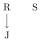

In [27]:
# params: (target, parents, list parent_ncategories, list of distributions
pJgR = DiscreteCPD(:J, :R, [2],
    [Categorical([0.8, 0.2]), # p(J | R=F) (wet due to something else)
     Categorical([0.0, 1.0])  # p(J | R=T)
    ])
push!(wg, pJgR)

In [ ]:
pJgR # Note: 1=false, 2=true

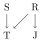

In [28]:
pTgRS = DiscreteCPD(:T, [:R, :S], [2, 2], 
    [Categorical([1.0, 0.0]), # p(T | R=F, S=F)
     Categorical([0.0, 1.0]), # p(T | R=T, S=F)
     Categorical([0.1, 0.9]), # p(T | R=F, S=T)
     Categorical([0.0, 1.0])  # P(T | R=T, S=T)
    ])

push!(wg, pTgRS)

In [29]:
pTgRS

,T,R,S,potential
,Int64,Int64,Int64,Float64
1,1,1,1,1.0
2,2,1,1,0.0
3,1,2,1,0.0
4,2,2,1,1.0
5,1,1,2,0.1
6,2,1,2,0.9
7,1,2,2,0.0
8,2,2,2,1.0


To compute $p(S|T = \textsf{true})$:

In [30]:
infer(wg, [:S], evidence=Assignment(:T=>2))

,S,potential
,Int64,Float64
1,1,0.661765
2,2,0.338235


which matches Barber (3.1.11).  Now look what happens if Tracey also observes that her neighbor Jack's grass is also wet (Barber 3.1.15):

In [31]:
infer(wg, [:S], evidence=Assignment(:T=>2, :J=>2))

,S,potential
,Int64,Float64
1,1,0.839552
2,2,0.160448


The probability goes *down*.  Another way of saying this is that the most likely explanation for why Jack's grass is wet is rain, which "*explains away*" the cause of the sprinkler.  

If Tracey observes Jack's grass is not wet, then the only explanation (with this model) is that she forgot to turn off her sprinkler.

In [32]:
infer(wg, [:S], evidence=Assignment(:T=>2, :J=>1))

,S,potential
,Int64,Float64
1,1,0.0
2,2,1.0
